In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached fortitudo_tech-1.1.12-py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.3-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached protobuf-6.33.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.ma

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
import yfinance as yf
from cvxopt import matrix, solvers
from copy import copy
from time import time

In [3]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = ['^GSPC', 'AMT', 'PLD', 'CCI', 'EQIX', 'DLR', 'PSA', 'SPG', 'O', 'WELL', 'AVB',
    'EQR', 'ESS', 'MAA', 'UDR', 'VTR', 'VNO', 'SLG', 'BXP', 'ARE', 'CBRE',
    'VICI', 'INVH', 'KIM', 'REG', 'FRT', 'HST', 'AIV', 'CPT',
    'IRM', 'EXR', 'SBAC', 'MAC', 'WY']

data = data[[t for t in selected_assets if t in data.columns]]

data_clean = data.dropna(axis=1, how='any')
vix_raw = yf.download('^VIX', start=data_clean.index[0], end=data_clean.index[-1], progress=False)
vix = vix_raw['Close']['^VIX'] if isinstance(vix_raw.columns, pd.MultiIndex) else vix_raw['Close']
vix = vix.reindex(data_clean.index).ffill().dropna()
common_dates = data_clean.index.intersection(vix.index)
asset_data = data_clean.loc[common_dates]
vix = vix.loc[common_dates]
pnl = np.log(asset_data / asset_data.shift(1)).dropna()

print(f"Assets: {asset_data.shape[1]} | Days: {len(asset_data)} | Range: {asset_data.index[0].date()} to {asset_data.index[-1].date()}")
print(f"{np.round(len(pnl) / 252, 2)} years of daily data.")

/tmp/ipykernel_299/1306655786.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=data_clean.index[0], end=data_clean.index[-1], progress=False)


Assets: 32 | Days: 2471 | Range: 2016-01-04 to 2025-11-11
9.8 years of daily data.


In [4]:
 # print(data.columns.tolist())

In [5]:
stats = ft.simulation_moments(pnl.values * 100)
stats.index = pnl.columns
stats.head(10)

,Mean,Volatility,Skewness,Kurtosis
^GSPC,0.049567,1.151132,-0.684761,19.452357
AMT,0.035748,1.638634,-0.163636,11.592899
PLD,0.055927,1.720768,-0.651153,13.728794
CCI,0.020288,1.595424,-0.132322,9.477237
EQIX,0.048873,1.720534,-0.183036,9.074034
DLR,0.045960,1.782767,-0.166546,8.839863
PSA,0.020724,1.472472,-0.656024,7.943139
SPG,0.018630,2.349409,-1.032394,37.254626
O,0.022984,1.671367,-3.318046,67.696274
WELL,0.057138,2.042342,-0.945132,35.175040


In [6]:
vix_aligned = vix.loc[pnl.index].values

imp_vol_25pct = np.percentile(vix_aligned, 25)
imp_vol_90pct = np.percentile(vix_aligned, 90)

low_vol_indices = vix_aligned <= imp_vol_25pct
mid_vol_indices = (vix_aligned > imp_vol_25pct) & (vix_aligned <= imp_vol_90pct)
high_vol_indices = vix_aligned > imp_vol_90pct

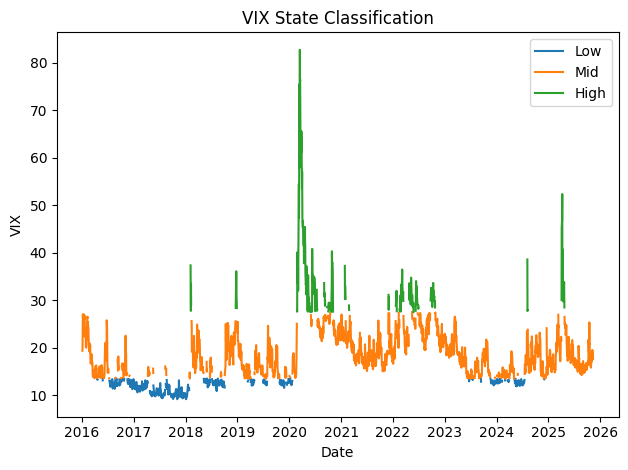

In [7]:
vol_low = np.ma.masked_where(~low_vol_indices, vix_aligned)
vol_mid = np.ma.masked_where(~mid_vol_indices, vix_aligned)
vol_high = np.ma.masked_where(~high_vol_indices, vix_aligned)

plt.plot(pnl.index, vol_low, label='Low')
plt.plot(pnl.index, vol_mid, label='Mid')
plt.plot(pnl.index, vol_high, label='High')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.title('VIX State Classification')
plt.tight_layout()
plt.show()

In [8]:
T_tilde = len(pnl)
I = pnl.shape[1]
log_returns = pnl.values

p_exp = ft.exp_decay_probs(log_returns, half_life=T_tilde / 2)

mu_low = np.mean(vix_aligned[low_vol_indices])
sigma_low = np.std(vix_aligned[low_vol_indices])
mu_mid = np.mean(vix_aligned[mid_vol_indices])
sigma_mid = np.std(vix_aligned[mid_vol_indices])
mu_high = np.mean(vix_aligned[high_vol_indices])
sigma_high = np.std(vix_aligned[high_vol_indices])

A = np.vstack((np.ones((1, T_tilde)), vix_aligned[np.newaxis, :]))
b_low = np.array([[1.], [mu_low]])
b_mid = np.array([[1.], [mu_mid]])
b_high = np.array([[1.], [mu_high]])

G = vix_aligned[np.newaxis, :] ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
states_vector = 0 * low_vol_indices.astype(int) + 1 * mid_vol_indices.astype(int) + 2 * high_vol_indices.astype(int)

S = 10000
H = 21
np.random.seed(1)

sim_indices = resampling(S, H, states_vector[-1], states_prob, states_vector)
return_sim_1m = np.exp(np.cumsum(log_returns[sim_indices], axis=1))[:, -1, :] - 1

print(f"Simulations: {S} | Horizon: {H} days | Assets: {I}")
print(f"Return simulation shape: {return_sim_1m.shape}")
print(f"Current regime: {'Low' if states_vector[-1] == 0 else 'Mid' if states_vector[-1] == 1 else 'High'}")

Simulations: 10000 | Horizon: 21 days | Assets: 32
Return simulation shape: (10000, 32)
Current regime: Mid


In [9]:
stats_sim = ft.simulation_moments(100 * return_sim_1m)
stats_sim.index = pnl.columns
stats_sim.head(10)

,Mean,Volatility,Skewness,Kurtosis
^GSPC,1.941607,4.556962,-0.576385,5.585929
AMT,1.604828,6.994104,0.065936,3.502977
PLD,2.280552,7.452317,-0.074880,3.929904
CCI,1.002975,6.861986,0.094853,3.723585
EQIX,1.705731,7.487370,0.151762,3.840850
DLR,1.669172,7.701062,0.228620,3.654402
PSA,1.005864,6.325985,-0.030488,3.470100
SPG,2.174243,8.695047,0.261422,5.420474
O,0.959860,5.906538,-0.070961,3.984773
WELL,2.486623,7.656251,0.009704,5.505716


In [10]:
G = -np.eye(I)
h = np.zeros(I)

cvar_opt = ft.MeanCVaR(return_sim_1m, G, h)

print(f"Optimizer initialized | Assets: {I} | Simulations: {return_sim_1m.shape[0]}")

Optimizer initialized | Assets: 32 | Simulations: 10000


In [11]:
return_target = np.mean(np.mean(return_sim_1m, axis=0))

start_time = time()
e_opt_prior = cvar_opt.efficient_portfolio(return_target)
print(f"Prior CVaR efficient portfolio | S={S} scenarios | I={I} assets | Time: {np.round(time() - start_time, 2)}s")

Prior CVaR efficient portfolio | S=10000 scenarios | I=32 assets | Time: 0.05s


In [12]:
# Verify prior results
tol = 1e-10  # tolerance for numerical deviations from bounds
assert np.abs(np.sum(e_opt_prior) - 1) <= tol  # sum to 1
assert np.all(e_opt_prior >= 0 - tol)  # long-only
assert np.abs(np.mean(return_sim_1m @ e_opt_prior) - return_target) <= tol  # return target

In [13]:
view_col = '^GSPC'
view_idx = pnl.columns.get_loc(view_col)
view_multiplier = 0.8  # This a mean view

A_ep = np.vstack((np.ones((1, S)), return_sim_1m[:, view_idx][np.newaxis, :]))
b_ep = np.array([[1], [np.mean(return_sim_1m[:, view_idx]) * view_multiplier]])
q = ft.entropy_pooling(np.ones((S, 1)) / S, A_ep, b_ep)

print(f"View on: {view_col} (index {view_idx}) | Target: {(view_multiplier - 1) * 100:+.0f}% relative change in expected return")

View on: ^GSPC (index 0) | Target: -20% relative change in expected return


In [14]:
cvar_opt_post = ft.MeanCVaR(return_sim_1m, G, h, p=q)
return_target_post = np.mean(q.T @ return_sim_1m)

start_time = time()
e_opt_post = cvar_opt_post.efficient_portfolio(return_target_post)
print(f"Posterior CVaR efficient portfolio | S={S} scenarios | I={I} assets | Time: {np.round(time() - start_time, 2)}s")

Posterior CVaR efficient portfolio | S=10000 scenarios | I=32 assets | Time: 0.05s


In [15]:
# Verify posterior results
assert np.abs(np.sum(e_opt_post) - 1) <= tol  # sum to 1
assert np.all(e_opt_post >= 0 - tol)  # long-only
assert np.abs(q.T @ return_sim_1m @ e_opt_post - return_target_post) <= tol  # return target

In [16]:
exposures = pd.DataFrame({
    'Prior': e_opt_prior.flatten() * 100,
    'Posterior': e_opt_post.flatten() * 100,
    'Difference': (e_opt_post - e_opt_prior).flatten() * 100
}, index=pnl.columns)

exposures = exposures.sort_values('Posterior', ascending=False)
exposures[exposures['Posterior'] > 0.1]

,Prior,Posterior,Difference
^GSPC,54.130984,50.029956,-4.101028
PSA,17.301399,18.451850,1.150452
O,15.538150,14.378022,-1.160127
DLR,6.374517,10.528513,4.153996
AMT,4.983483,5.653832,0.670349
IRM,1.671468,0.957826,-0.713642


In [17]:
prior_ret = return_sim_1m.mean(axis=0) @ e_opt_prior.flatten()
posterior_ret = (q.T @ return_sim_1m).flatten() @ e_opt_post.flatten()

print(f"Expected 1M Return | Prior: {prior_ret * 100:.2f}% | Posterior: {posterior_ret * 100:.2f}%")
print(f"Annualized Return  | Prior: {prior_ret * 12 * 100:.2f}% | Posterior: {posterior_ret * 12 * 100:.2f}%")

Expected 1M Return | Prior: 1.61% | Posterior: 1.28%
Annualized Return  | Prior: 19.28% | Posterior: 15.38%


In [18]:
prior_tickers = exposures[exposures['Prior'] > 0.5].index.tolist()
posterior_tickers = exposures[exposures['Posterior'] > 0.5].index.tolist()

print(f"Prior tickers ({len(prior_tickers)}): {prior_tickers}")
print(f"Posterior tickers ({len(posterior_tickers)}): {posterior_tickers}")

Prior tickers (6): ['^GSPC', 'PSA', 'O', 'DLR', 'AMT', 'IRM']
Posterior tickers (6): ['^GSPC', 'PSA', 'O', 'DLR', 'AMT', 'IRM']


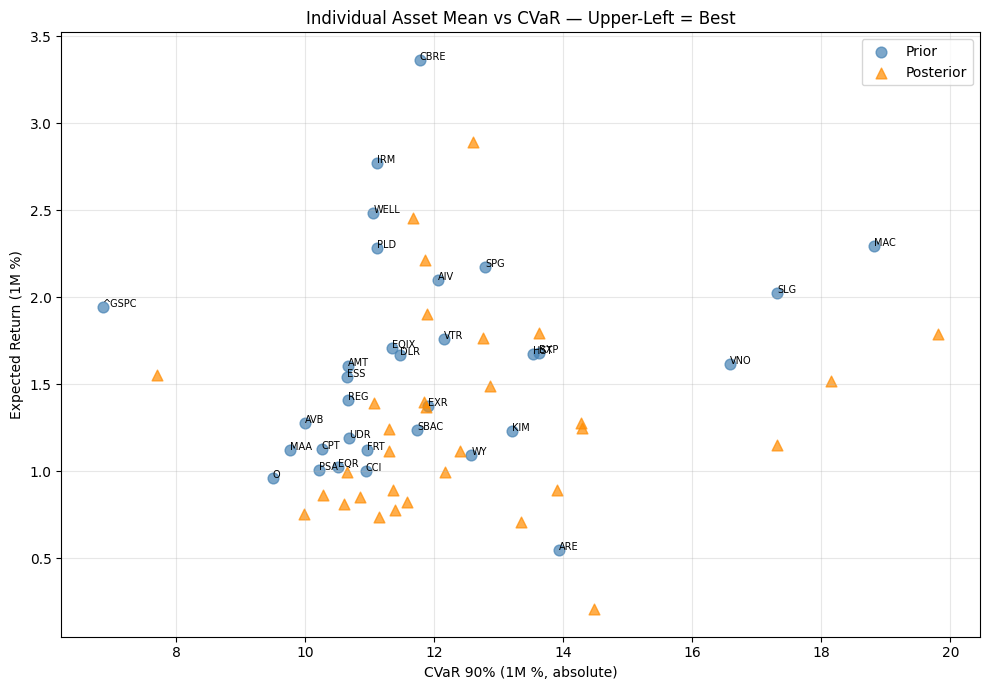

Top 10 Most Efficient (Prior):
       Mean Prior  CVaR Prior  Eff Prior
CBRE       3.3645    -11.7777     0.2857
^GSPC      1.9416     -6.8661     0.2828
IRM        2.7724    -11.1176     0.2494
WELL       2.4866    -11.0542     0.2249
PLD        2.2806    -11.1181     0.2051
AIV        2.0967    -12.0637     0.1738
SPG        2.1742    -12.7860     0.1700
AMT        1.6048    -10.6663     0.1505
EQIX       1.7057    -11.3466     0.1503
DLR        1.6692    -11.4620     0.1456
Top 10 Most Efficient (Posterior):
       Mean Post  CVaR Post  Eff Post
CBRE      2.8906   -12.5970    0.2295
IRM       2.4561   -11.6656    0.2105
^GSPC     1.5533    -7.6993    0.2017
WELL      2.2123   -11.8628    0.1865
PLD       1.9038   -11.8836    0.1602
AIV       1.7644   -12.7569    0.1383
SPG       1.7952   -13.6172    0.1318
AMT       1.3900   -11.0728    0.1255
EQIX      1.4001   -11.8460    0.1182
VTR       1.4926   -12.8630    0.1160


In [19]:
# Prior (equal-weighted)
alpha = 0.9
sim_mean_prior = return_sim_1m.mean(axis=0) * 100

# Posterior (q-weighted)
q_flat = q.flatten()
sim_mean_post = (q_flat @ return_sim_1m) * 100

def weighted_cvar(returns, probs, alpha):
    cvar = np.zeros(returns.shape[1])
    for i in range(returns.shape[1]):
        sorted_idx = np.argsort(returns[:, i])
        sorted_ret = returns[sorted_idx, i]
        sorted_p = probs[sorted_idx]
        cum_p = np.cumsum(sorted_p)
        tail_idx = cum_p <= (1 - alpha)
        cvar[i] = np.average(sorted_ret[tail_idx], weights=sorted_p[tail_idx]) if tail_idx.sum() > 0 else sorted_ret[0]
    return cvar

p_prior = np.ones(S) / S
sim_cvar_prior = weighted_cvar(return_sim_1m, p_prior, alpha) * 100
sim_cvar_post = weighted_cvar(return_sim_1m, q_flat, alpha) * 100

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(-sim_cvar_prior, sim_mean_prior, alpha=0.7, s=60, label='Prior', c='steelblue')
plt.scatter(-sim_cvar_post, sim_mean_post, alpha=0.7, s=60, label='Posterior', c='darkorange', marker='^')

for i, ticker in enumerate(pnl.columns):
    plt.annotate(ticker, (-sim_cvar_prior[i], sim_mean_prior[i]), fontsize=7)

plt.xlabel('CVaR 90% (1M %, absolute)')
plt.ylabel('Expected Return (1M %)')
plt.title('Individual Asset Mean vs CVaR — Upper-Left = Best')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ranking
ranking = pd.DataFrame({
    'Mean Prior': sim_mean_prior,
    'Mean Post': sim_mean_post,
    'CVaR Prior': sim_cvar_prior,
    'CVaR Post': sim_cvar_post,
    'Eff Prior': sim_mean_prior / (-sim_cvar_prior),
    'Eff Post': sim_mean_post / (-sim_cvar_post)
}, index=pnl.columns)

print("Top 10 Most Efficient (Prior):")
print(ranking.sort_values('Eff Prior', ascending=False)[['Mean Prior', 'CVaR Prior', 'Eff Prior']].head(10).round(4))

print("Top 10 Most Efficient (Posterior):")
print(ranking.sort_values('Eff Post', ascending=False)[['Mean Post', 'CVaR Post', 'Eff Post']].head(10).round(4))